### RFM Analysis

In [1]:
import time
import numpy as np
import pandas as pd
from base_model import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
dtypes = {
    'ORDERDATE': object,
    'ORDERID': object, 
    'AMOUNTINFO': np.float32, 
} # 设置每列数据类型
data = pd.read_csv('sales.csv', index_col='USERID', dtype=dtypes)

In [3]:
data.head(5) # 简单看看数据

,ORDERDATE,ORDERID,AMOUNTINFO
USERID,,,
142074,2016-01-01,4196439032,9399.0
56927,2016-01-01,4198324983,8799.0
87058,2016-01-01,4191287379,6899.0
136104,2016-01-01,4198508313,5999.0
117831,2016-01-01,4202238313,5399.0


In [4]:
data.describe() # 数据的简单描述统计

,AMOUNTINFO
count,86127.000000
mean,744.705261
std,1425.211182
min,0.500000
25%,13.000000
50%,59.000000
75%,629.000000
max,30999.000000


#### 1、异常值处理

In [5]:
data.isnull().any(axis=0) # 查看有缺失值的列

ORDERDATE      True
ORDERID       False
AMOUNTINFO     True
dtype: bool

In [6]:
data.isnull().any(axis=1).sum() # 统计有缺失值的记录（行）个数

10

In [7]:
data[data.isnull().any(axis=1)] # 展示缺失数据的记录

,ORDERDATE,ORDERID,AMOUNTINFO
USERID,,,
75849,2016-01-01,4197103430,NaN
103714,NaN,4136159682,189.0
155209,2016-01-01,4177940815,NaN
139877,NaN,4111956196,6.3
54599,2016-01-01,4119525205,NaN
65456,2016-01-02,4195643356,NaN
122134,2016-09-21,3826649773,NaN
116995,2016-10-24,3981569421,NaN
98888,2016-12-06,3814398698,NaN


In [8]:
data_tra = data.dropna() # 去掉缺失值数据

In [9]:
data_tra.describe()

,AMOUNTINFO
count,86125.000000
mean,744.720276
std,1425.224243
min,0.500000
25%,13.000000
50%,59.000000
75%,629.000000
max,30999.000000


#### 2、日期格式转换

In [10]:
data_tra['ORDERDATE'] = pd.to_datetime(data_tra['ORDERDATE'], format='%Y-%m-%d')
data_tra.dtypes

ORDERDATE     datetime64[ns]
ORDERID               object
AMOUNTINFO           float32
dtype: object

In [84]:
print data_tra['ORDERDATE'].max()
print data_tra['ORDERDATE'].min()

2016-12-29 00:00:00
2016-01-01 00:00:00


#### 3、数据转换

In [11]:
# 计算原始最近一次的订单
recency = data_tra['ORDERDATE'].groupby(data_tra.index).max()

In [12]:
# 计算原始订单频率
frequency = data_tra['ORDERDATE'].groupby(data_tra.index).count()

In [13]:
# 计算原始订单总金额
monetary = data_tra['AMOUNTINFO'].groupby(data_tra.index).sum()

#### 4、计算RFM得分

In [14]:
# R得分
deadline = pd.datetime(2017,01,01)
r_interval = (deadline - recency).dt.days # 计算R间距
r_score = pd.cut(r_interval, 5 ,labels=[5,4,3,2,1])

In [15]:
# F得分
f_score = pd.cut(frequency, 5, labels=[1,2,3,4,5])

In [16]:
# M得分
m_score = pd.cut(monetary, 5, labels=[1,2,3,4,5])

In [17]:
rfm_list = [r_score, f_score, m_score]
rfm_cols = ['r_score', 'f_score', 'm_score']
rfm_df = pd.DataFrame(np.array(rfm_list).transpose(),
                     dtype=np.int32,
                     columns=rfm_cols,
                     index=frequency.index)

In [18]:
rfm_df.head(5)

,r_score,f_score,m_score
USERID,,,
51220,4,1,1
51221,2,1,1
51224,3,1,1
51225,4,1,1
51226,1,1,1


#### 5、计算RFM总得分

In [19]:
# 加权得分
rfm_df['rfm_wscore'] = rfm_df['r_score']*0.6 + rfm_df['f_score']*0.3 + rfm_df['m_score']*0.1
rfm_df.head(4)

,r_score,f_score,m_score,rfm_wscore
USERID,,,,
51220,4,1,1,2.8
51221,2,1,1,1.6
51224,3,1,1,2.2
51225,4,1,1,2.8


In [20]:
# RFM组合
# rfm_df_tmp = rfm_df.copy()
# rfm_df_tmp['r_score'] = rfm_df_tmp['r_score'].astype('string')
# rfm_df_tmp['f_score'] = rfm_df_tmp['f_score'].astype('string')
# rfm_df_tmp['m_score'] = rfm_df_tmp['m_score'].astype('string')
# rfm_df['rfm_comb'] = rfm_df_tmp['r_score'].str.cat(rfm_df_tmp['f_score']).str.cat(rfm_df_tmp['m_score'])
rfm_df['rfm_comb'] = rfm_df.r_score.map(str) + rfm_df.f_score.map(str) + rfm_df.m_score.map(str)
rfm_df.head(5)

,r_score,f_score,m_score,rfm_wscore,rfm_comb
USERID,,,,,
51220,4,1,1,2.8,411
51221,2,1,1,1.6,211
51224,3,1,1,2.2,311
51225,4,1,1,2.8,411
51226,1,1,1,1.0,111


In [21]:
rfm_df.describe()

,r_score,f_score,m_score,rfm_wscore
count,60496.000000,60496.000000,60496.000000,60496.000000
mean,3.306665,1.014348,1.000132,2.388317
std,1.401301,0.119753,0.018182,0.845130
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.600000
50%,3.000000,1.000000,1.000000,2.500000
75%,5.000000,1.000000,1.000000,3.400000
max,5.000000,5.000000,5.000000,5.000000


        r_score count
r_score              
1                8824
2               10239
3               11247
4               13933
5               16253
        f_score count
f_score              
1               59631
2                 864
5                   1
        m_score count
m_score              
1               60491
2                   4
5                   1
            rfm_wscore count
rfm_wscore                  
1.0                   8822.0
1.3                      2.0
1.6                  10224.0
1.7                      1.0
1.9                     14.0
2.2                  11163.0
2.5                     83.0
2.6                      1.0
2.8                  13689.0
2.9                      2.0
3.1                    242.0
3.4                  15730.0
3.7                    522.0
5.0                      1.0
         rfm_comb count
rfm_comb               
111                8822
121                   2
211               10224
212                   1
221               

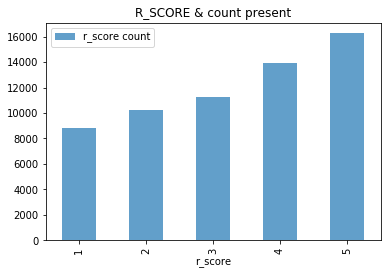

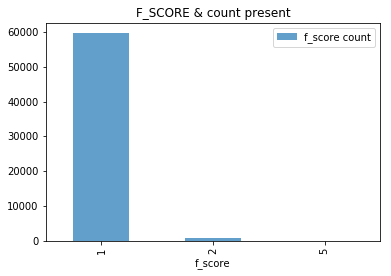

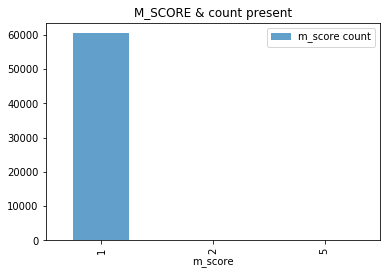

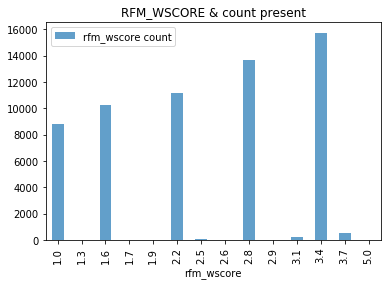

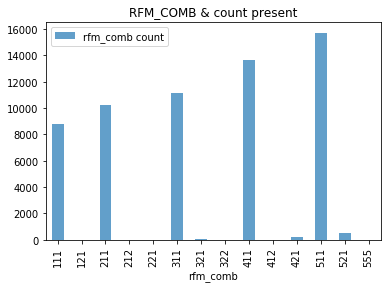

In [79]:
for column in rfm_df.columns.tolist():
    tmp = pd.DataFrame(columns=[column, '%s count'%column])
    for i in sorted(rfm_df[column].unique().tolist()):
        cnt = rfm_df[rfm_df[column]==i][column].count()
        tmp = tmp.append({
            column:i,
            '%s count'%column:cnt,
        }, ignore_index=True)
    tmp.index = tmp[column]; del tmp[column]
    tmp.plot.bar(title='%s & count present'%column.upper(), alpha=0.7)
    print tmp

In [81]:
rfm_df.loc[74270]
# 客户消费状态不乐观，主要体现在消费频率，消费金额，其主要原因是有一个用户消费额高，消费频率也高，导致区间向大值区域偏移

r_score         5
f_score         5
m_score         5
rfm_wscore      5
rfm_comb      555
Name: 74270, dtype: object

#### 小插曲 pandas.cat

In [22]:
# cat(self, others=None, sep=None, na_rep=None)
'''
:param other: 要合并的另一个对象，如果为空则合并左侧的组合
:param sep: 合并的分隔符，默认为空
:param na_rep: 如果遇到NA缺失值时如何处理，默认忽略
'''
print '{:-^60}'.format('示例一')
print pd.Series(['a','b','c']).str.cat(sep='--')
print '{:-^60}'.format('示例二')
print pd.Series(['a','b','c']).str.cat(['A','B','C'], sep='!=')
# 更多信息可以help(pd.Series.cat)

-------------------------示例一--------------------------
a--b--c
-------------------------示例二--------------------------
0    a!=A
1    b!=B
2    c!=C
dtype: object


#### 6、写入数据库

In [23]:
# 数据库设置
table_name = 'sales_rfm_score'
config = {
    "host" : "localhost",
    "port" : 3306,
    "username" : "root",
    "password" : "root",
    "dbname" : "work",
    "charset" : "utf8",
}
table_define = {
    'table_name' : table_name,
    'table_primary_key' : [],
    'table_indexs' : [],
    'table_uniques' : [],
    'table_options': [],
    'table_fields' : [
        ('`userid`', 'VARCHAR(20)', 'NOT NULL'),
        ('`r_score`', 'int(2)', 'NOT NULL'),
        ('`f_score`', 'int(2)', 'NOT NULL'),
        ('`m_score`', 'int(2)', 'NOT NULL'),
        ('`rfm_wscore`', 'DECIMAL(10,2)'),
        ('`rfm_comb`', 'VARCHAR(10)'),
    ],
}

In [27]:
sql = BaseModel.gen_create_table_sql(table_define)
model = BaseModel(config)
model._query_table(sql)

INFO [2019-02-21 20:57:58,871][base_model.py:54][4461:MainThread] excute sql done[runtime: 0, args: ('SET autocommit=1;',), kwargs: {}, host_info: 127.0.0.1 via TCP/IP]
INFO [2019-02-21 20:57:58,887][base_model.py:54][4461:MainThread] excute sql done[runtime: 0, args: ('CREATE TABLE IF NOT EXISTS `sales_rfm_score` (\n `userid` VARCHAR(20) NOT NULL,\n `r_score` int(2) NOT NULL,\n `f_score` int(2) NOT NULL,\n `m_score` int(2) NOT NULL,\n `rfm_wscore` DECIMAL(10,2),\n `rfm_comb` VARCHAR(10),\n `insert_time` int(10) NOT NULL DEFAULT 0,\n `update_time` int(10) NOT NULL DEFAULT 0\n) ENGINE=InnoDB DEFAULT CHARSET=utf8 \n ;',), kwargs: {}, host_info: 127.0.0.1 via TCP/IP]


0L

In [28]:
insert_param, key_list = [],[]
for index, row in rfm_df.iterrows():
    row = row.to_dict()
    row['userid'] = index
    row['insert_time'] = int(time.time())
    insert_param.append(row.values())
    if not key_list: key_list = row.keys()
    if len(insert_param) >= 10000:
        model._insert_table_many(table_name, key_list, insert_param)
        insert_param = []
model._insert_table_many(table_name, key_list, insert_param)

INFO [2019-02-21 20:58:01,102][base_model.py:289][4461:MainThread] insert many finish[sql: INSERT INTO `sales_rfm_score` (`m_score`,`userid`,`f_score`,`rfm_comb`,`rfm_wscore`,`insert_time`,`r_score`) VALUES(%s,%s,%s,%s,%s,%s,%s) ON DUPLICATE KEY UPDATE `update_time`=1550753880;, row: 10000]
INFO [2019-02-21 20:58:02,755][base_model.py:289][4461:MainThread] insert many finish[sql: INSERT INTO `sales_rfm_score` (`m_score`,`userid`,`f_score`,`rfm_comb`,`rfm_wscore`,`insert_time`,`r_score`) VALUES(%s,%s,%s,%s,%s,%s,%s) ON DUPLICATE KEY UPDATE `update_time`=1550753882;, row: 10000]
INFO [2019-02-21 20:58:04,390][base_model.py:289][4461:MainThread] insert many finish[sql: INSERT INTO `sales_rfm_score` (`m_score`,`userid`,`f_score`,`rfm_comb`,`rfm_wscore`,`insert_time`,`r_score`) VALUES(%s,%s,%s,%s,%s,%s,%s) ON DUPLICATE KEY UPDATE `update_time`=1550753884;, row: 10000]
INFO [2019-02-21 20:58:06,005][base_model.py:289][4461:MainThread] insert many finish[sql: INSERT INTO `sales_rfm_score` (`m

### [实战 Retail Transaction Data From Kaggle](https://www.kaggle.com/regivm/retailtransactiondata/). 

Context
----
The data provides customer and date level transactions for few years. It can be used for demonstration of any analysis that require transaction information like RFM. The data also provide response information of customers to a promotion campaign.

Highlight of this dataset is that you can evaluate the effectiveness RFM group by checking the one of the business metric; the response of customers.

Content
---
Transaction data provides customer_id, transaction date and Amount of purchase. Response data provides the response information of each of the customers. It is a binary variable indicating whether the customer responded to a campaign or not.

Acknowledgements
---
Extremely thankful numerous kernel and data publishers of Kaggle and Github. Learnt a lot from these communities.

Inspiration
---
More innovative approaches for handling RFM Analysis.

In [85]:
import time
import numpy as np
import pandas as pd
from base_model import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [86]:
data = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])
data.head(5)

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
customer_id    125000 non-null object
trans_date     125000 non-null datetime64[ns]
tran_amount    125000 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [88]:
data.describe()

,tran_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


In [89]:
data.isnull().any(axis=0)

customer_id    False
trans_date     False
tran_amount    False
dtype: bool

In [90]:
data.isnull().any(axis=1).sum()
# 无缺失值

0

In [91]:
deadline = pd.datetime(2015,4,1)
data['time_interval'] = deadline - data['trans_date']
data['time_interval'].astype('timedelta64[D]')
data['time_interval'] = data['time_interval'] / np.timedelta64(1, 'D')
data.head()

,customer_id,trans_date,tran_amount,time_interval
0,CS5295,2013-02-11,35,779.0
1,CS4768,2015-03-15,39,17.0
2,CS2122,2013-02-26,52,764.0
3,CS1217,2011-11-16,99,1232.0
4,CS1850,2013-11-20,78,497.0


In [113]:
# 只取最近两年的数据分析
data = data[data['time_interval']<365*2]
data.shape

(63633, 4)

In [176]:
rfm_df = data.groupby('customer_id')\
    .agg({
        'time_interval': lambda x:x.min(),# Recency
        'customer_id': lambda x: len(x),# Frequency
        'tran_amount': lambda x: x.sum()# Monetary Value
    })          
rfm_df.rename(columns={
                'time_interval': 'recency', 
                'customer_id': 'frequency', 
                'tran_amount': 'monetary_value'},inplace=True)

In [177]:
cols = rfm_df.columns.to_list()
rfm_df.head(4)

,recency,frequency,monetary_value
customer_id,,,
CS1112,77.0,6,358
CS1113,51.0,11,775
CS1114,48.0,11,804
CS1115,27.0,10,765


In [178]:
# 基于四分位数进行切分
quartiles = rfm_df.quantile(q=[0.25,0.50,0.75]).to_dict()
for col in cols:
    bins = [0, quartiles[col][0.25], quartiles[col][0.50], quartiles[col][0.75], float('inf')]
    label = [1,2,3,4] if col=='recency' else [4,3,2,1]
    rfm_df['%s_score'%col] = pd.cut(rfm_df[col], bins, labels=label)
    rfm_df['%s_score'%col] = rfm_df['%s_score'%col].astype('int32')
rfm_df.head(4)

,recency,frequency,monetary_value,recency_score,frequency_score,monetary_value_score
customer_id,,,,,,
CS1112,77.0,6,358,3,4,4
CS1113,51.0,11,775,2,2,2
CS1114,48.0,11,804,2,2,1
CS1115,27.0,10,765,1,2,2


In [179]:
# RFM组合
rfm_df_tmp = rfm_df.copy()
rfm_df_tmp['recency_score'] = rfm_df_tmp['recency_score'].astype('string')
rfm_df_tmp['frequency_score'] = rfm_df_tmp['frequency_score'].astype('string')
rfm_df_tmp['monetary_value_score'] = rfm_df_tmp['monetary_value_score'].astype('string')
rfm_df['rfm_comb'] = rfm_df_tmp['recency_score'].str.cat(rfm_df_tmp['frequency_score']).str.cat(rfm_df_tmp['monetary_value_score'])
rfm_df.head(5)

,recency,frequency,monetary_value,recency_score,frequency_score,monetary_value_score,rfm_comb
customer_id,,,,,,,
CS1112,77.0,6,358,3,4,4,344
CS1113,51.0,11,775,2,2,2,222
CS1114,48.0,11,804,2,2,1,221
CS1115,27.0,10,765,1,2,2,122
CS1116,219.0,5,333,4,4,4,444


In [180]:
rfm_df['Total_Score'] = rfm_df['recency_score'] + rfm_df['frequency_score'] +rfm_df['monetary_value_score']
rfm_df.head(4)

,recency,frequency,monetary_value,recency_score,frequency_score,monetary_value_score,rfm_comb,Total_Score
customer_id,,,,,,,,
CS1112,77.0,6,358,3,4,4,344,11
CS1113,51.0,11,775,2,2,2,222,6
CS1114,48.0,11,804,2,2,1,221,5
CS1115,27.0,10,765,1,2,2,122,5


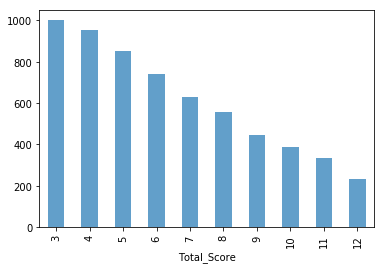

In [181]:
rfm_df.groupby('Total_Score').agg('monetary_value').mean().plot.bar(alpha=0.7)

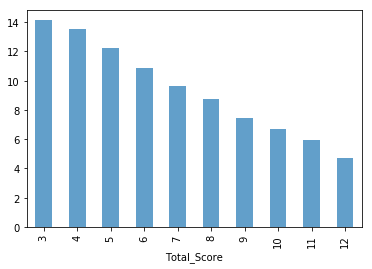

In [182]:
rfm_df.groupby('Total_Score').agg('frequency').mean().plot.bar(alpha=0.7)

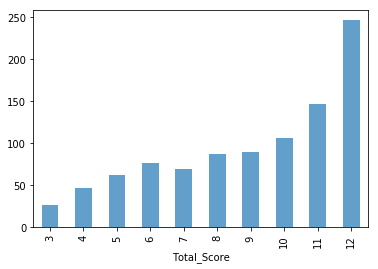

In [183]:
rfm_df.groupby('Total_Score').agg('recency').mean().plot.bar(alpha=0.7)

In [184]:
# 与客户响应数据合并
res = pd.read_csv('Retail_Data_Response.csv')
res.sort_values('customer_id', inplace=True)
res.head(4)

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1


In [185]:
# 重置index，index自动变成新增列
rfm_df.reset_index(inplace=True)
rfm_df.head(4)

,customer_id,recency,frequency,monetary_value,recency_score,frequency_score,monetary_value_score,rfm_comb,Total_Score
0,CS1112,77.0,6,358,3,4,4,344,11
1,CS1113,51.0,11,775,2,2,2,222,6
2,CS1114,48.0,11,804,2,2,1,221,5
3,CS1115,27.0,10,765,1,2,2,122,5


In [186]:
rfm_df.sort_values('customer_id', inplace=True)
rfm_df_ = pd.merge(rfm_df, res, on='customer_id')

In [187]:
rfm_df_.head(5)

,customer_id,recency,frequency,monetary_value,recency_score,frequency_score,monetary_value_score,rfm_comb,Total_Score,response
0,CS1112,77.0,6,358,3,4,4,344,11,0
1,CS1113,51.0,11,775,2,2,2,222,6,0
2,CS1114,48.0,11,804,2,2,1,221,5,1
3,CS1115,27.0,10,765,1,2,2,122,5,1
4,CS1116,219.0,5,333,4,4,4,444,12,1


Text(0,0.5,'Proportion of Responders')

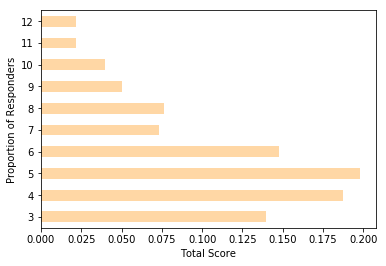

In [190]:
ax=rfm_df_.groupby('Total_Score').agg('response').mean().plot(kind='barh', colormap='copper_r', alpha=.7)
ax.set_xlabel("Total Score")
ax.set_ylabel("Proportion of Responders")

In [191]:
## 可以看出客户响应比例和综合得分有一定的联系，客户主要群体在3~6得分，虽然他们的表现不怎么好